Рассмотрим сегментирование изображений с помощью глубоких нейросетевых архитектур на примере [Mask R-CNN](https://arxiv.org/abs/1703.06870) с использованием [torchvision](https://pytorch.org/vision/stable/index.html).

Импортируем требуемые библиотеки и загрузим предобученную модель.

In [56]:
import os
from os.path import exists, join, basename, splitext

import random
import PIL
import torchvision
import cv2
import numpy as np
import torch
torch.set_grad_enabled(False)
  
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model = model.eval().cpu()

Загрузим и считаем изображение

In [57]:
!gdown 14CSVdok0NTd9NRHKv2WXg34Z7Wykui8A
image_file = 'sheep.jpg'

Downloading...
From: https://drive.google.com/uc?id=14CSVdok0NTd9NRHKv2WXg34Z7Wykui8A
To: /home/anton202/study/AdvancedMLDeepLearning/ex_12/example_image.jpg
100%|████████████████████████████████████████| 164k/164k [00:00<00:00, 7.06MB/s]


Произведем сегментацию изображения при помощи модели

In [58]:
t = time.time()
image = PIL.Image.open(image_file)
image_tensor = torchvision.transforms.functional.to_tensor(image).cpu()
output = model([image_tensor])[0]
print('Время распознавания: %.3fs' % (time.time() - t))

Время распознавания: 1.470s


В качестве результата возвращается словарь со следующими ключами:

Результаты работы модели находятся в словаре:

*   boxes -- bounding boxes обнаруженных объектов (в виде <code>x1, y1, x2, y2</code> — отсчет начинается от левого верхнего края изображения)
*   labels -- метки назначенных классов
*   scores -- вероятности отнесения к назначенным классам
*   masks -- маски -- результат сегментации

Обратим внимание на то, что значения интенсивностей пикселей масок и координаты коробок (bounding boxes) не являются целыми числами. В дальнейшем, исправим это.






In [59]:
output.keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

Данная модель способна определить более 90 различных объектов. Соответствующий файл скачивается в формате .json, который нетрудно распарсить средствами питона. Но для данной темы достаточно определить эти типы объектов явным образом.

In [60]:
coco_names = ['unlabeled', 'sheep']

Произведем небольшое преобразование, а именно -- отберем только те обнаруженные объекты, в которых модель относительно уверена (значение score больше 0.5), произведем бинаризацию значений масок и актуализируем значения bounding boxes.

In [96]:
result = {}
result['masks'] = []
result['labels'] = []
result['scores'] = []
result['boxes'] = []

for i in range(len(output['scores'])):
  if output['scores'][i] <= 0.5:
    continue
  # Исправляем маски
  one_mask = output['masks'][i][0].cpu().numpy()
  one_mask[one_mask >= np.max(one_mask) * 0.5] = 1
  one_mask[one_mask < np.max(one_mask) * 0.5] = 0
  result['masks'].append(one_mask)
  # Исправляем коробки
  result['boxes'].append(output['boxes'][i].int().cpu().numpy())
  # Добавляем остальное
  result['scores'].append(output['scores'][i].cpu().numpy())
  result['labels'].append(output['labels'][i].cpu().numpy())

print(len(result['masks']))
print(len(result['labels']))
print(len(result['scores']))
print(len(result['boxes']))


areas = []
for mask in result['masks']:
    mask = mask.squeeze()
    areas.append(np.sum(mask))

# Поиск объекта с наибольшей площадью
max_area = max(areas)
print(areas)
max_area_index = areas.index(max_area)
print(max_area_index)
print(result['scores'][max_area_index])
result['boxes'][max_area_index]
print()

object_area = np.sum(result['masks'][0])
image_area = result['masks'][0].shape[0] * result['masks'][0].shape[1]
area_fraction = object_area / image_area
print("Доля площади объекта относительно площади изображения:", area_fraction)



19
19
19
19
[1886.0, 1612.0, 1052.0, 1425.0, 1639.0, 1735.0, 703.0, 1170.0, 599.0, 1022.0, 992.0, 460.0, 626.0, 513.0, 594.0, 490.0, 414.0, 595.0, 141.0]
0
0.99844944



Проиллюстрируем результат

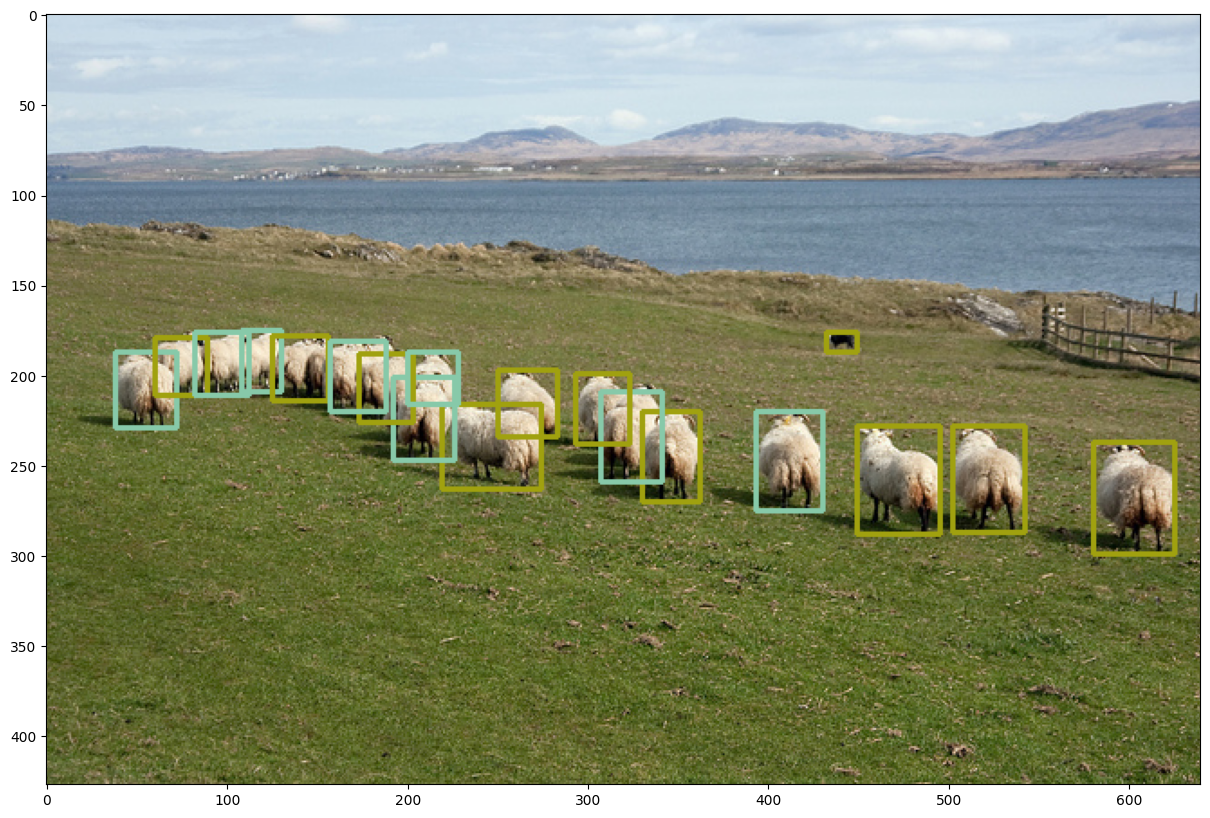

In [53]:
colors = [[random.randint(0, 255) for _ in range(3)] for _ in coco_names]

result_image = np.array(image.copy())
for box, label, score, mask in zip(result['boxes'], result['labels'], result['scores'], result['masks']):
  color = random.choice(colors)
  
  # draw box
  tl = round(0.002 * max(result_image.shape[0:2])) + 1  # line thickness
  c1, c2 = (box[0], box[1]), (box[2], box[3])
  cv2.rectangle(result_image, c1, c2, color, thickness=tl)
  # # draw text
  # display_txt = "%s: %.1f%%" % (coco_names[label], 100*score)
  # tf = max(tl - 1, 1)  # font thickness
  # t_size = cv2.getTextSize(display_txt, 0, fontScale=tl / 3, thickness=tf)[0]
  # c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
  # cv2.rectangle(result_image, c1, c2, color, -1)  # filled
  # cv2.putText(result_image, display_txt, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
  
plt.figure(figsize=(15, 10))
plt.imshow(result_image)

Посмотрим на полученные маски

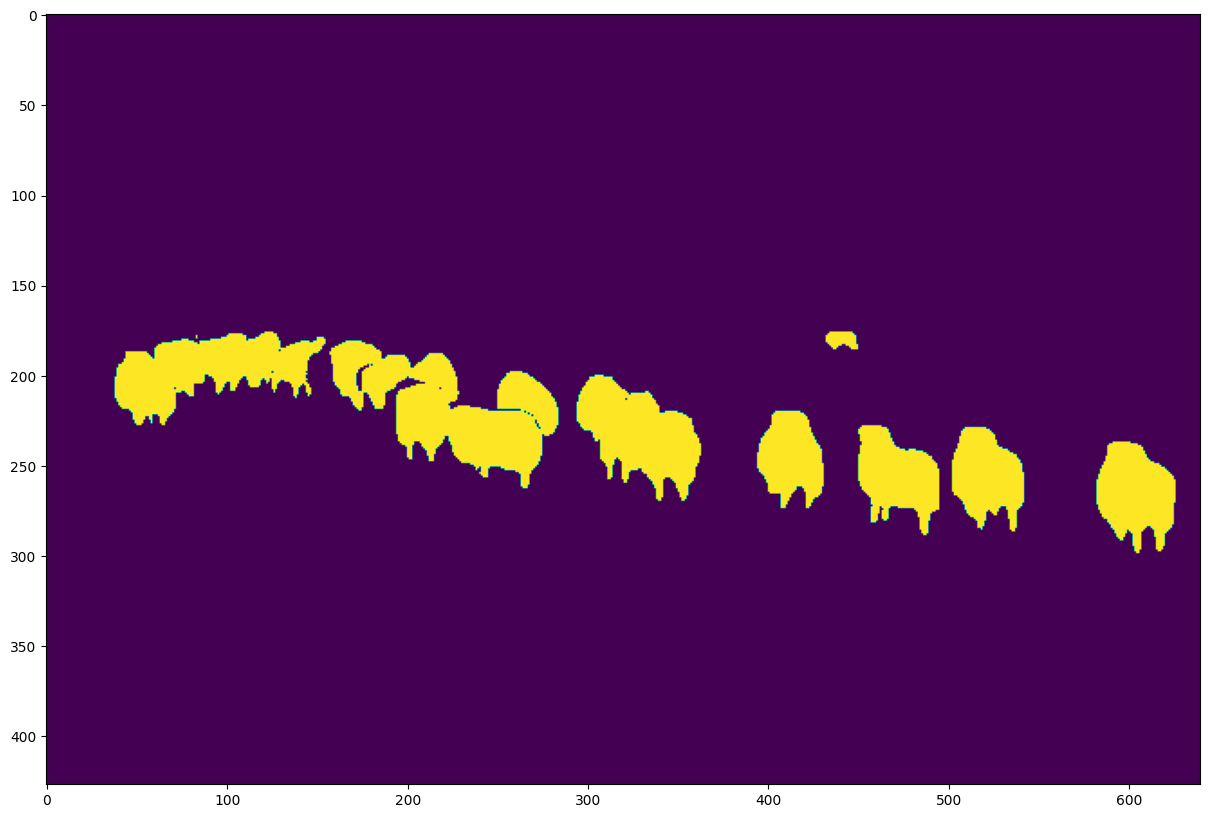

In [54]:
all_masks = np.sum(result['masks'],axis=0)
all_masks[all_masks > 1] = 1
plt.figure(figsize=(15, 10))
plt.imshow(all_masks)

In [48]:
print(len(all_masks))

areas = []
for mask in all_masks:
    mask = mask.squeeze()
    areas.append(np.sum(mask))

# Поиск объекта с наибольшей площадью
max_area = max(areas)
max_area_index = areas.index(max_area)
print(max_area_index)
print(output.get('scores')[244])

# # Вывод объекта с наибольшей площадью
# plt.imshow(max_area_index)



# segmented_image = np.zeros_like(all_masks[max_area_index])
# segmented_image[mask[max_area_index] > 0.5] = 255

# print(len(segmented_image))
# # plt.imshow(segmented_image)

427
244


IndexError: index 244 is out of bounds for dimension 0 with size 38